# Notebook of the segmentation and the extraction of handmade features.

# Data import

In [ ]:
!pip install pyhdust

In [ ]:
import os
from PIL import Image
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import ConvNextImageProcessor, ConvNextForImageClassification
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.morphology import convex_hull_image
import cv2
import pyhdust.images as phim
from skimage.morphology import convex_hull_image
from scipy import ndimage
from skimage.filters import threshold_minimum, threshold_yen, threshold_isodata, threshold_otsu

In [ ]:
!pip install kaggle
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dlmi-lymphocytosis-classification

 97% 277M/286M [00:02<00:00, 142MB/s]
100% 286M/286M [00:02<00:00, 113MB/s]


In [ ]:
!unzip /content/dlmi-lymphocytosis-classification.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: trainset/P27/000009.jpg  
  inflating: trainset/P27/000010.jpg  
  inflating: trainset/P27/000011.jpg  
  inflating: trainset/P27/000012.jpg  
  inflating: trainset/P27/000013.jpg  
  inflating: trainset/P27/000014.jpg  
  inflating: trainset/P27/000015.jpg  
  inflating: trainset/P27/000016.jpg  
  inflating: trainset/P27/000017.jpg  
  inflating: trainset/P27/000018.jpg  
  inflating: trainset/P27/000019.jpg  
  inflating: trainset/P27/000020.jpg  
  inflating: trainset/P27/000021.jpg  
  inflating: trainset/P27/000022.jpg  
  inflating: trainset/P27/000023.jpg  
  inflating: trainset/P27/000024.jpg  
  inflating: trainset/P27/000025.jpg  
  inflating: trainset/P27/000026.jpg  
  inflating: trainset/P27/000027.jpg  
  inflating: trainset/P27/000028.jpg  
  inflating: trainset/P27/000029.jpg  
  inflating: trainset/P27/000030.jpg  
  inflating: trainset/P27/000031.jpg  
  inflating: trainset/P27

# Creation of the dataset

In [ ]:
class PatientDataset(Dataset):
    """
    For each patient get a dict with:
    - 'images': list of different images,
    - 'age': age
    - 'lymph_count': lymph_count
    - 'gender': gender - can be useful
    - 'label': label - useful during training, useless during test
    - 'id': id - useless during training, usefull during test for submission
    """
    def __init__(self, csv_file, root_dir, transform=None, ids = None):
        self.data_frame = pd.read_csv(csv_file)
        self.data_frame['GENDER'] = self.data_frame['GENDER'].replace(['f'],['F']) # Some samples were labeled as 'f' instead of 'F'
        self.root_dir = root_dir
        self.transform = transform
        self.ids = ids

    def __len__(self):
        if self.ids is not None:
          return len(self.ids)
        else:
          return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.ids is not None:
          idx = self.ids[idx]

        img_dir = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        images = [Image.open(os.path.join(img_dir, img_name)) for img_name in os.listdir(img_dir)]

        id = self.data_frame.iloc[idx, 0]
        label = self.data_frame.iloc[idx, 1]
        gender = 1 if self.data_frame.iloc[idx, 2] == 'M' else 0
        age = self.calculate_age(self.data_frame.iloc[idx, 3])
        lymph_count = self.data_frame.iloc[idx, 4]

        sample = {'images': images, 'age': age, 'lymph_count': lymph_count, 'gender': gender, 'label': label, 'id': id}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def calculate_age(self, dob):
        year = int(dob[-4:])
        return 2024-year

class TestTransform(object):
  """ Useful class to turn our image into tensor """
  def __call__(self, sample):
    images, age, lymph_count, gender, label, id = sample['images'], sample['age'], sample['lymph_count'], sample['gender'], sample['label'], sample['id']
    images = [transforms.ToTensor()(img) for img in images]
    return {'images': images, 'age': age, 'lymph_count': lymph_count, 'gender': gender, 'label': label, 'id': id}

class TrainTransform(object):
  def __call__(self, sample):
    images, age, lymph_count, gender, label, id = sample['images'], sample['age'], sample['lymph_count'], sample['gender'], sample['label'], sample['id']
    transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.ToTensor()
                                  ])

    images = [transform(img) for img in images]
    return {'images': images, 'age': age, 'lymph_count': lymph_count, 'gender': gender, 'label': label, 'id': id}

In [ ]:
def k_fold_balanced(dataframe, nb_folds=5):
  n_0 = dataframe.groupby('LABEL').nunique()['ID'][0]
  p_0 = n_0/len(dataframe)
  n_1 = dataframe.groupby('LABEL').nunique()['ID'][1]
  p_1 = n_1/len(dataframe)
  datasets_list = list()
  n_list = list()
  # Pick ids depending on sizes and proportions
  shuffled_0 = dataframe.index[dataframe['LABEL']==0].tolist()
  np.random.shuffle(shuffled_0)
  shuffled_1 = dataframe.index[dataframe['LABEL']==1].tolist()
  np.random.shuffle(shuffled_1)
  fold_size_0 = n_0 // nb_folds
  nb_remained_0 = n_0 % nb_folds
  start_ind_0 = 0
  fold_size_1 = n_1 // nb_folds
  nb_remained_1 = n_1 % nb_folds
  start_ind_1 = 0

  for i in range(nb_folds):


    if nb_remained_0 > 0:
      i_fold_size_0 = fold_size_0 + 1
      nb_remained_0 -= 1
    else:
      i_fold_size_0 = fold_size_0

    if nb_remained_1 > 0:
      i_fold_size_1 = fold_size_1 + 1
      nb_remained_1 -= 1
    else:
      i_fold_size_1 = fold_size_1

    end_ind_0 = start_ind_0 + i_fold_size_0
    end_ind_1 = start_ind_1 + i_fold_size_1
    train_0 = shuffled_0[start_ind_0: end_ind_0]
    train_1 = shuffled_1[start_ind_1: end_ind_1]

    train_ids = train_0 + train_1
    np.random.shuffle(train_ids)

    train_dataframe=dataframe.loc[train_ids]

    n_0_train = train_dataframe.groupby('LABEL').nunique()['ID'][0]
    n_1_train = train_dataframe.groupby('LABEL').nunique()['ID'][1]

    train_dataset = PatientDataset(csv_file='/content/trainset/trainset_true.csv',
                                   root_dir='/content/trainset/',
                                   transform=transforms.Compose([
                                       TrainTransform(),
                                   ]),
                                   ids = train_ids)

    datasets_list.append(train_dataset)
    n_list.append((n_0_train, n_1_train))

  return datasets_list, n_list

In [ ]:
dataframe = pd.read_csv('/content/trainset/trainset_true.csv')
dataframe['GENDER'] = dataframe['GENDER'].replace(['f'],['F'])

datasets_list, n_list = k_fold_balanced(dataframe)

In [ ]:
testset = PatientDataset(csv_file='/content/testset/testset_data.csv',
                         root_dir='/content/testset/',
                         transform=transforms.Compose([
                             TestTransform(),
                         ]))

testloader = DataLoader(testset,
                        batch_size=1,
                        shuffle=True)

# Segmentation

In [ ]:
trainloader = DataLoader(datasets_list[0],
                         batch_size=1,
                         shuffle=True)

In [ ]:
sample = next(iter(trainloader))
print(f"For this patient we have {len(sample['images'])} images of size {sample['images'][0].shape}.")
print(f"The trainloader comprises {len(trainloader)} samples")
sample['label'].item()

For this patient we have 45 images of size torch.Size([1, 3, 224, 224]).
The trainloader comprises 33 samples


0

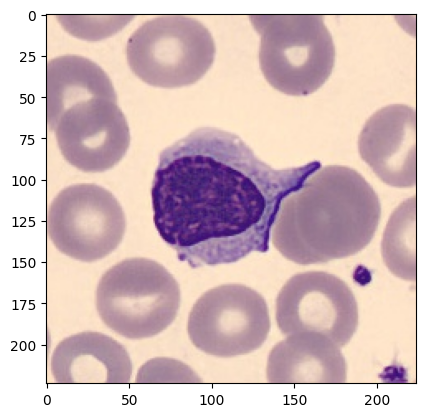

In [ ]:
img = sample['images'][4].squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img)
plt.show()

Segmentation implementation from the article *New segmentation and feature extraction algorithm for classifcation of white blood cells in peripheral smear images*

We begin with the global function and then show each step of it

In [ ]:
def keep_largest_component(mask):
    # Label connected components in the mask
    labeled_mask, num_labels = ndimage.measurements.label(mask)

    # Count the size of each connected component
    component_sizes = ndimage.measurements.sum(mask, labeled_mask, range(1, num_labels+1))

    # Find the index of the largest connected component
    largest_component_index = np.argmax(component_sizes)

    # Create a new mask with only the largest connected component
    largest_component_mask = labeled_mask == largest_component_index + 1

    # Fill holes in the largest component
    filled_mask = ndimage.binary_fill_holes(largest_component_mask)

    return filled_mask

In [ ]:
def segmentation(img):
  """
  Take a numpy image and return the segmentation of the nucleus, the convex hull and the roc image, in numpy format in order to extract features.
  """

  # Set values between 0 and 255
  img_np = (img * 255).astype(np.uint8)

  # Color balancing
  mean_rgb = np.mean(img_np, axis=(0, 1))
  gray_img = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
  mean_gray_img = np.mean(gray_img)
  img_balanced = (img_np * mean_gray_img / mean_rgb).astype(np.uint8)

  # Mask from CMYK color space
  cmyk_image = phim.rgb2cmyk(img_balanced)
  m, k = cmyk_image[..., 1].astype(np.float32), cmyk_image[..., 3].astype(np.float32)
  km = np.maximum(k-m, 0)

  # S component from HLS color space
  s = cv2.cvtColor(img_balanced, cv2.COLOR_RGB2HLS_FULL)[..., 2]

  # Combination to obtain the soft map image
  ms = np.minimum(m, s)
  soft_map = np.maximum(ms-km, 0)

  # Otsu algo and keep 1 component
  t = threshold_otsu(soft_map)
  nucleus = keep_largest_component(soft_map > t)

  # Convex hull of the nucleus and ROC image
  hull = convex_hull_image(nucleus)
  roc = hull^nucleus

  return nucleus, hull, roc

In [ ]:
nucleus, hull, roc = segmentation(sample['images'][1].squeeze(0).permute(1, 2, 0).numpy())

<ipython-input-14-8e8f62e02d00>:3: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  labeled_mask, num_labels = ndimage.measurements.label(mask)
<ipython-input-14-8e8f62e02d00>:6: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  component_sizes = ndimage.measurements.sum(mask, labeled_mask, range(1, num_labels+1))


Here step by step

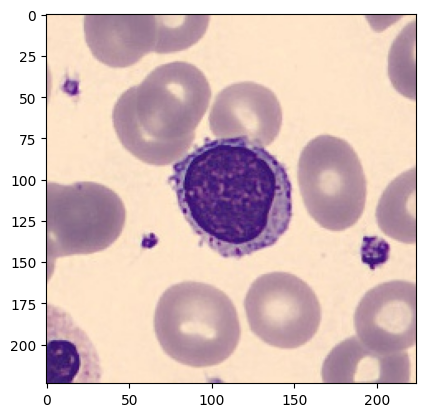

In [ ]:
img = sample['images'][20].squeeze(0).permute(1, 2, 0).numpy()
img = (img * 255).astype(np.uint8)
plt.imshow(img)
plt.show()

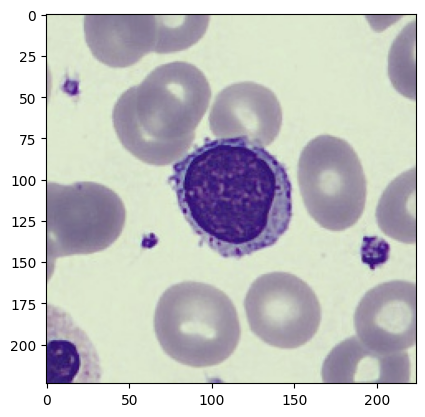

In [ ]:
# Step 1: Color Balancing
mean_rgb = np.mean(img, axis=(0, 1))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mean_gray_img = np.mean(gray_img)
img_balanced = (img * mean_gray_img / mean_rgb).astype(np.uint8)
plt.imshow(img_balanced)
plt.show()

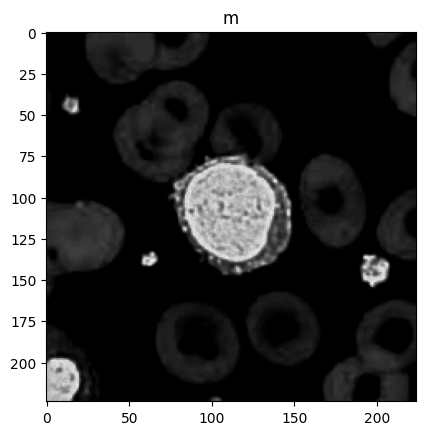

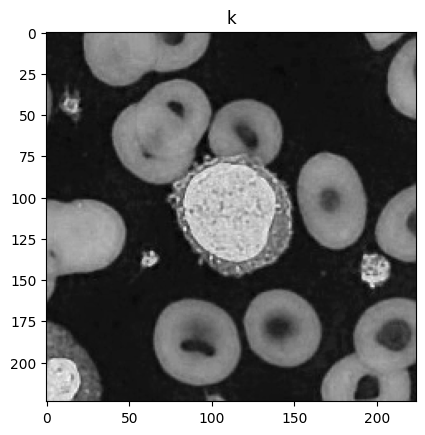

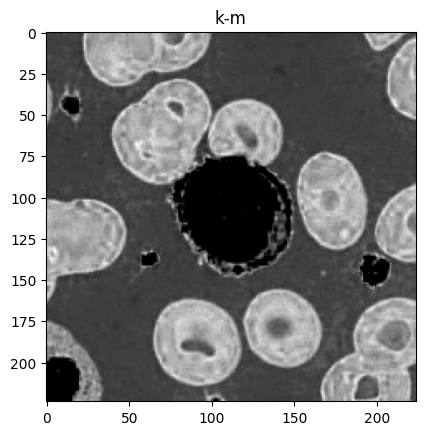

In [ ]:
cmyk_image = phim.rgb2cmyk(img_balanced)

m, k = cmyk_image[..., 1].astype(np.float32), cmyk_image[..., 3].astype(np.float32)
km = np.maximum(k - m, 0)

plt.imshow(m, cmap='gray')
plt.title('m')
plt.show()

plt.imshow(k, cmap='gray')
plt.title('k')
plt.show()

plt.imshow(km, cmap='gray')
plt.title('k-m')
plt.show()

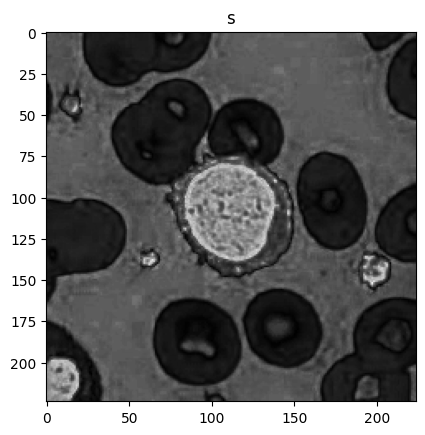

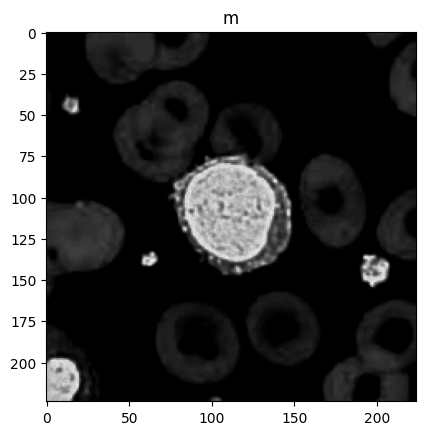

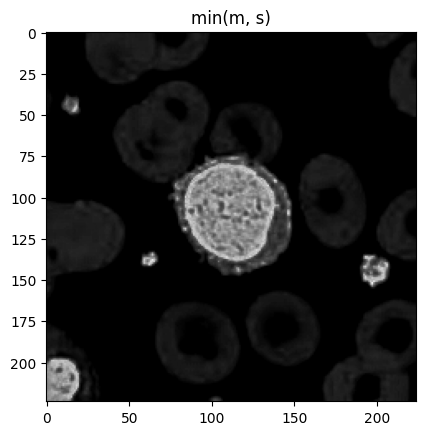

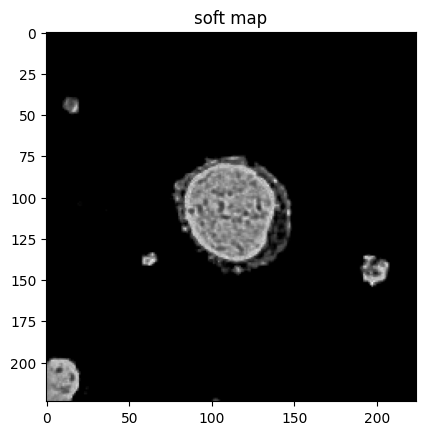

In [ ]:
s = cv2.cvtColor(img_balanced, cv2.COLOR_RGB2HLS_FULL)[..., 2]
ms = np.minimum(m, s)
soft_map = np.maximum(ms-km, 0)
plt.imshow(s, cmap='gray')
plt.title('s')
plt.show()
plt.imshow(m, cmap='gray')
plt.title('m')
plt.show()
plt.imshow(ms, cmap='gray')
plt.title('min(m, s)')
plt.show()
plt.imshow(soft_map, cmap='gray')
plt.title('soft map')
plt.show()

<ipython-input-14-8e8f62e02d00>:3: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  labeled_mask, num_labels = ndimage.measurements.label(mask)
<ipython-input-14-8e8f62e02d00>:6: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  component_sizes = ndimage.measurements.sum(mask, labeled_mask, range(1, num_labels+1))


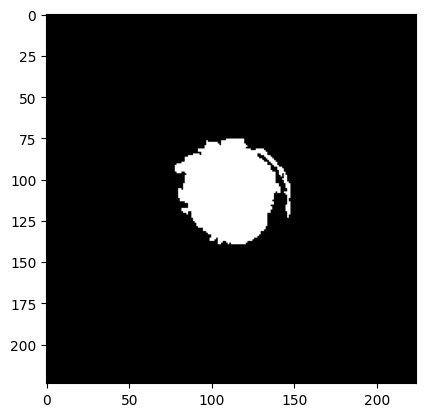

In [ ]:
t = threshold_otsu(soft_map)
mask = keep_largest_component(soft_map > t)
plt.imshow(mask, cmap='gray')

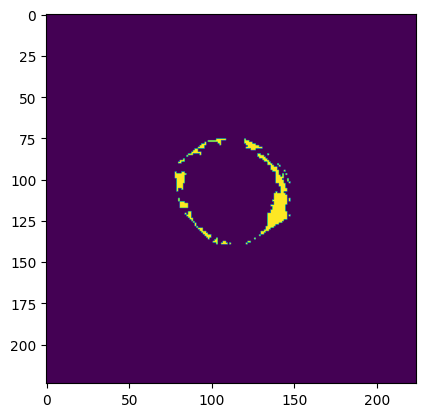

In [ ]:
hull = convex_hull_image(mask)
roc = hull^mask
plt.imshow(roc)
plt.show()

#Extraction of features

We use the features describe in the same article.

In [ ]:
def solidity(nucleus, convex_hull):
  return nucleus.sum() / convex_hull.sum()

def convexity(nucleus, convex_hull):
  contours_nucleus = measure.find_contours(nucleus, 0.5)
  perimeter_nucleus = np.sum(np.sqrt(np.diff(contours_nucleus[0][:, 0])**2 + np.diff(contours_nucleus[0][:, 1])**2))
  contours_convex_hull = measure.find_contours(convex_hull, 0.5)
  perimeter_convex_hull = np.sum(np.sqrt(np.diff(contours_convex_hull[0][:, 0])**2 + np.diff(contours_convex_hull[0][:, 1])**2))
  return perimeter_convex_hull / perimeter_nucleus

def circularity(nucleus):
  contours_nucleus = measure.find_contours(nucleus, 0.5)
  perimeter_nucleus = np.sum(np.sqrt(np.diff(contours_nucleus[0][:, 0])**2 + np.diff(contours_nucleus[0][:, 1])**2))
  area_nucleus = nucleus.sum()
  return (perimeter_nucleus**2) / (4*np.pi*area_nucleus)

solidity(mask, hull), convexity(mask, hull), circularity(mask)

(0.8556671449067432, 0.5891294302194022, 3.759968620721982)

In [ ]:
def mean_nuc_hull(nucleus, convex_hull):
  return np.mean(nucleus) / np.mean(convex_hull)

def std_nuc_hull(nucleus, convex_hull):
  return np.std(nucleus) / np.std(convex_hull)

def mean_roc_hull(roc, convex_hull):
  return np.mean(roc) / np.mean(convex_hull)

def std_roc_hull(roc, convex_hull):
  return np.std(roc) / np.std(convex_hull)

In [ ]:
def get_features(dataloader):
  """
  Include id, label, gender, age, lymph_count
  """
  x = list()
  y = list()

  for data in tqdm(dataloader):
    y.append(data['label'].item())
    features_images = list()
    for img in data['images']:
      features_img = list()
      features_img.append(data['id'])
      img = img.squeeze(0).permute(1, 2, 0).numpy()
      nucleus, hull, roc = segmentation(img)
      features_img.append(solidity(nucleus, hull))
      features_img.append(convexity(nucleus, hull))
      features_img.append(circularity(nucleus))
      all_channels = list()
      # RGB
      all_channels.append(img[..., 0])
      all_channels.append(img[..., 1])
      all_channels.append(img[..., 2])
      #HSV
      hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
      all_channels.append(hsv[:, :, 0]) # channel H : index 3
      all_channels.append(hsv[:, :, 1]) # channel S : index 4
      all_channels.append(hsv[:, :, 2]) # channel V : index 5
      #lab
      lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
      all_channels.append(lab[:, :, 0]) # channel L : index 6
      all_channels.append(lab[:, :, 1]) # channel A : index 7
      all_channels.append(lab[:, :, 2]) # channel BB : index 8
      #YCrCb
      ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
      all_channels.append(ycrcb[:, :, 0]) # channel Y : index 9
      all_channels.append(ycrcb[:, :, 1]) # channel Cr : index 10
      all_channels.append(ycrcb[:, :, 2]) # channel Cb : index 11
      for channel in all_channels:
        nucleus_int = channel[nucleus > 0]
        hull_int = channel[hull > 0]
        roc_int = channel[roc > 0]
        features_img.append(mean_nuc_hull(nucleus_int, hull_int))
        features_img.append(std_nuc_hull(nucleus_int, hull_int))
        features_img.append(mean_roc_hull(roc_int, hull_int))
        features_img.append(std_roc_hull(roc_int, hull_int))
      features_img.append(data['lymph_count'])
      features_img.append(data['age'])
      features_img.append(data['gender'])
      features_images.append(features_img)
    x.append(features_images)

  return x, y

In [ ]:
x = []
y = []
for dataset in datasets_list:
  dataloader = DataLoader(dataset,
                           batch_size=1,
                           shuffle=True)

  x_split, y_split = get_features(dataloader)
  x.append(x_split)
  y.append(y_split)

  0%|          | 0/33 [00:00<?, ?it/s]<ipython-input-14-8e8f62e02d00>:3: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  labeled_mask, num_labels = ndimage.measurements.label(mask)
<ipython-input-14-8e8f62e02d00>:6: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  component_sizes = ndimage.measurements.sum(mask, labeled_mask, range(1, num_labels+1))
  0%|          | 0/33 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def extract_features(dataloader):
  """
  Extrat the features to include them to the patient dataset.
  """
  features = list() # Contain (id, list_list_features)

  for data in tqdm(dataloader):
    features_images = list()
    id = data['id'][0]
    for img in data['images']:
      features_img = list()
      img = img.squeeze(0).permute(1, 2, 0).numpy()
      nucleus, hull, roc = segmentation(img)
      features_img.append(solidity(nucleus, hull))
      features_img.append(convexity(nucleus, hull))
      features_img.append(circularity(nucleus))
      all_channels = list()
      # RGB
      all_channels.append(img[..., 0])
      all_channels.append(img[..., 1])
      all_channels.append(img[..., 2])
      #HSV
      hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
      all_channels.append(hsv[:, :, 0]) # channel H : index 3
      all_channels.append(hsv[:, :, 1]) # channel S : index 4
      all_channels.append(hsv[:, :, 2]) # channel V : index 5
      #lab
      lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
      all_channels.append(lab[:, :, 0]) # channel L : index 6
      all_channels.append(lab[:, :, 1]) # channel A : index 7
      all_channels.append(lab[:, :, 2]) # channel BB : index 8
      #YCrCb
      ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
      all_channels.append(ycrcb[:, :, 0]) # channel Y : index 9
      all_channels.append(ycrcb[:, :, 1]) # channel Cr : index 10
      all_channels.append(ycrcb[:, :, 2]) # channel Cb : index 11
      for channel in all_channels:
        nucleus_int = channel[nucleus > 0]
        hull_int = channel[hull > 0]
        roc_int = channel[roc > 0]
        features_img.append(mean_nuc_hull(nucleus_int, hull_int))
        features_img.append(std_nuc_hull(nucleus_int, hull_int))
        features_img.append(mean_roc_hull(roc_int, hull_int))
        features_img.append(std_roc_hull(roc_int, hull_int))
      features_images.append(features_img)
    features.append((id, features_images))

  return features

In [ ]:
trainset = PatientDataset(csv_file='/content/trainset/trainset_true.csv',
                          root_dir='/content/trainset/',
                          transform=transforms.Compose([
                              TrainTransform(),
                          ]))

trainloader = DataLoader(trainset,
                         batch_size=1,
                         shuffle=True)

features_train = extract_features(trainloader)

testloader = DataLoader(testset,
                        batch_size=1,
                        shuffle=True)

features_test = extract_features(testloader)

  0%|          | 0/163 [00:00<?, ?it/s]<ipython-input-14-8e8f62e02d00>:3: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  labeled_mask, num_labels = ndimage.measurements.label(mask)
<ipython-input-14-8e8f62e02d00>:6: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  component_sizes = ndimage.measurements.sum(mask, labeled_mask, range(1, num_labels+1))
100%|██████████| 42/42 [01:49<00:00,  2.62s/it]


In [ ]:
train_df_features = pd.DataFrame(features_train, columns=['ID', 'FEATURES'])
test_df_features = pd.DataFrame(features_test, columns=['ID', 'FEATURES'])
train_df_features.to_csv('train_df_features.csv', index=False)
test_df_features.to_csv('test_df_features.csv', index=False)